3D slicc preprocessing

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.io.image import load_nifti
import pandas as pd
import sklearn.cluster
import skimage.segmentation
#from fast_slic import Slic
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.filters import threshold_otsu
from skimage.filters import median
from skimage.color import rgb2gray
from scipy.stats import ttest_ind, norm

In [5]:
def evaluate_segmentation(seg_hat_flat, seg_flat, tumor_label):
    #coordinates of predicted and actual tumor
    y_coors = np.argwhere(seg_flat!=0)

    yhat_coors = np.argwhere(seg_hat_flat ==tumor_label)

    #size of tumor and non-tumor (number of voxels)
    tumor_size=len(y_coors)
    total_size = len(seg_flat)
    non_tumor_size = total_size-tumor_size


    #true positive
    correct_id_tumor = np.intersect1d(y_coors, yhat_coors)

    
    
    percent_tumor_correct = len(correct_id_tumor)/tumor_size

    #false positive
    false_positive_points = np.setdiff1d(yhat_coors, y_coors)
    false_positive = len(false_positive_points)/non_tumor_size

    #false negative
    false_neg_points = np.setdiff1d(y_coors, yhat_coors)
    false_neg = len(false_neg_points)/tumor_size

    
    #true negative
    true_negative=(total_size-(tumor_size+len(false_positive_points)))/non_tumor_size

    #Total error (misidentification
    total_incorrect_points = np.concatenate((false_neg_points, false_positive_points))
    total_error = len(total_incorrect_points)/total_size
    
    #percentage of yhat that is correct
    yhat_size = len(yhat_coors)
    correct_id_tumor_hat = np.intersect1d(yhat_coors, y_coors)
    specificity = len(correct_id_tumor_hat)/yhat_size
    
    #New metric, TP + specificity
    metric = (percent_tumor_correct + specificity)/2
    
    print("True Positive: ", percent_tumor_correct)
    print("False negative: ", false_neg)
    print("True Negative: ", true_negative)
    print("False Positive: ", false_positive)
    print("'specificity':", specificity)
    print("metric: ", metric)
    
    print("************")
    print("Total Error: ", total_error)

# Load MRI data

In [6]:
sample_flair_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_flair.nii"
sample_seg_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_seg.nii"


In [7]:
data_flair, affine, im = load_nifti(sample_flair_path, return_img=True)

In [8]:
data_seg, affine, im = load_nifti(sample_seg_path, return_img=True)

# Basic preprocessing, need RGB for slicc to work

In [9]:
#normalize
minval = np.min(data_flair)
maxval = np.max(data_flair)
flair_norm = (data_flair-minval)/(maxval-minval)

#median filter (noise reduction)
flair_norm  = median(flair_norm )



In [10]:
#convert to rGB color space - builtin does not give good range
flair_rgb = gray2rgb(flair_norm )
flair_rgb[100,100,60,:]

array([0.25515211, 0.25515211, 0.25515211])

In [20]:

flair_to_rgb = lambda x : np.array([2*x, 1-x, 1-x])

def rgb_to_flair(rgb_img):
    gray_img = np.zeros(240*240)
    for i in range(0, rgb_img.shape[0]):
        gray_img[i] = 1-rgb_img[i][2]


In [21]:
f =flair_rgb.flatten().reshape(240*240*155, 3)

In [22]:
rgb_to_flair(f)

IndexError: index 57600 is out of bounds for axis 0 with size 57600

In [187]:
flair_to_rgb(flair_norm.flatten())

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [188]:
flair_rgb = flair_to_rgb(flair_norm.flatten())

In [15]:
flair_rgb = (f).reshape(240, 240, 155, 3)

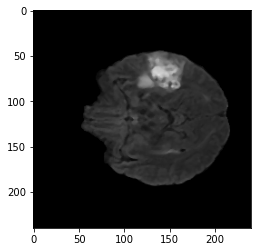

In [16]:
plt.figure()
plt.imshow(flair_rgb[:,:,60,:])
plt.show()

# Segment whole MRI using 2D superpixel slices

In [197]:
tolerance = 0.1
output = np.zeros(data_flair.shape)
for i in range(0, 155):
    slice_2d = flair_rgb[:,:,i,:]
    maxval = np.max(slice_2d)
#    if maxval > tolerance: #otherwise assume image has no tumor
    n_segments_2d = 300
    slic_mask_2d = skimage.segmentation.slic(slice_2d, n_segments=n_segments_2d, convert2lab=True, start_label=1)
    #slice_2d = rgb2gray(slice_2d)
    
    
    grayscale_slic_mask = slice_2d.reshape(240*240, 3)
    print(grayscale_slic_mask)
    slic_mask_2d = grayscale_slic_mask.reshape(slic_mask_2d.shape)

    
    
    labels2D = np.unique(slic_mask_2d)


    for label in labels2D:
        slice_2d[slic_mask_2d ==label]=np.average(slice_2d[slic_mask_2d ==label])
    print(np.max(slic_mask_2d))
    output[:,:,i]=slice_2d

    plt.figure()
    plt.imshow(slice_2d)
    plt.show()


#cluster_3d_masked = output[output > tolerance]

thresh_3d = threshold_otsu(cluster_3d_masked.flatten())
print(thresh_3d)
plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(cluster_3d_masked.flatten(), bins=50, log=True)
plt.axvline(x=thresh_3d, color="red")
plt.show()




IndexError: invalid index to scalar variable.

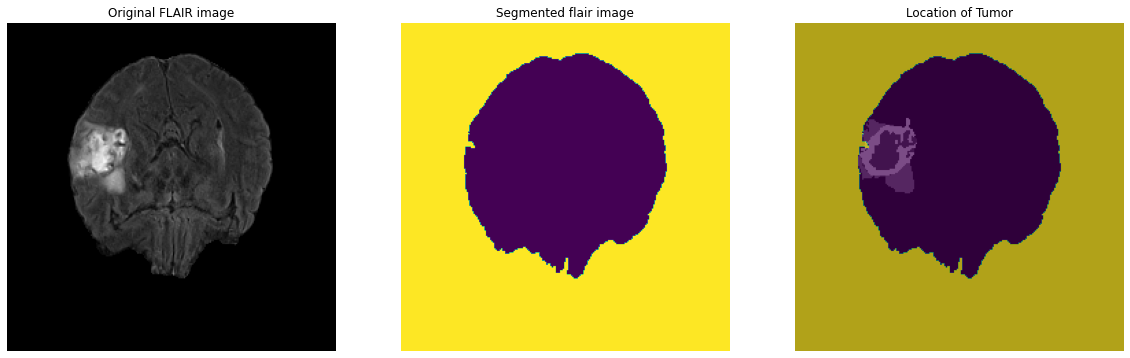

In [176]:
output[output< thresh_3d]=0
tumor_otsu_label = 1
output[output>0]=tumor_otsu_label


plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(output[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(output[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [147]:
evaluate_segmentation(output.flatten(), data_seg.flatten(), tumor_otsu_label)

True Positive:  0.996077707535416
False negative:  0.003922292464584007
True Negative:  0.8255426376569588
False Positive:  0.17445736234304124
'specificity': 0.027098243372002666
metric:  0.5115879754537094
************
Total Error:  0.17362948028673836


# T Test value

In [148]:
tumor_hat = (flair_norm[output>0]).flatten()
nontumor_hat = flair_norm[output ==0]
nontumor_hat = nontumor_hat[nontumor_hat> tolerance]

In [149]:
np.mean(tumor_hat)

0.1854290076380792

In [109]:
np.mean(nontumor_hat)

0.1819344853461763

In [110]:
ttest_ind(tumor_hat, nontumor_hat)

Ttest_indResult(statistic=1225.2852429914374, pvalue=0.0)

In [111]:
mean_diff = np.mean(tumor_hat) - np.mean(nontumor_hat)
mean_diff

0.26489675733701684

# T test with cleaned image

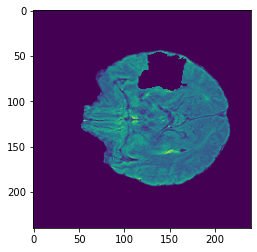

In [112]:
data_flair[data_seg>0]=0
plt.figure()
plt.imshow(data_flair[:,:,60])
plt.show()

In [113]:
#normalize
minval = np.min(data_flair)
maxval = np.max(data_flair)
flair_norm = (data_flair-minval)/(maxval-minval)

#median filter (noise reduction)
flair_norm  = median(flair_norm )

#convert to rGB color space
flair_rgb = gray2rgb(flair_norm )

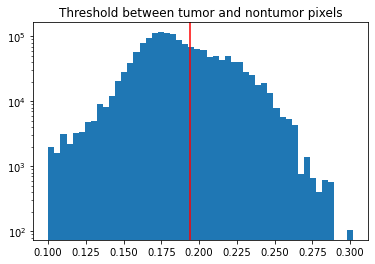

In [114]:
tolerance = 0.1
output = np.zeros(data_flair.shape)
for i in range(0, 155):
    slice_2d = flair_rgb[:,:,i,:]
    maxval = np.max(slice_2d)
    if maxval > tolerance: #otherwise assume image has no tumor
        n_segments_2d = 300
        slic_mask_2d = skimage.segmentation.slic(slice_2d, n_segments=n_segments_2d, start_label=1)
        slice_2d = rgb2gray(slice_2d)
        labels2D = np.unique(slic_mask_2d)
        

        for label in labels2D:
            slice_2d[slic_mask_2d ==label]=np.average(slice_2d[slic_mask_2d ==label])
        output[:,:,i]=slice_2d

         

cluster_3d_masked = output[output > tolerance]

thresh_3d = threshold_otsu(cluster_3d_masked)
plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(cluster_3d_masked.flatten(), bins=50, log=True)
plt.axvline(x=thresh_3d, color="red")
plt.show()




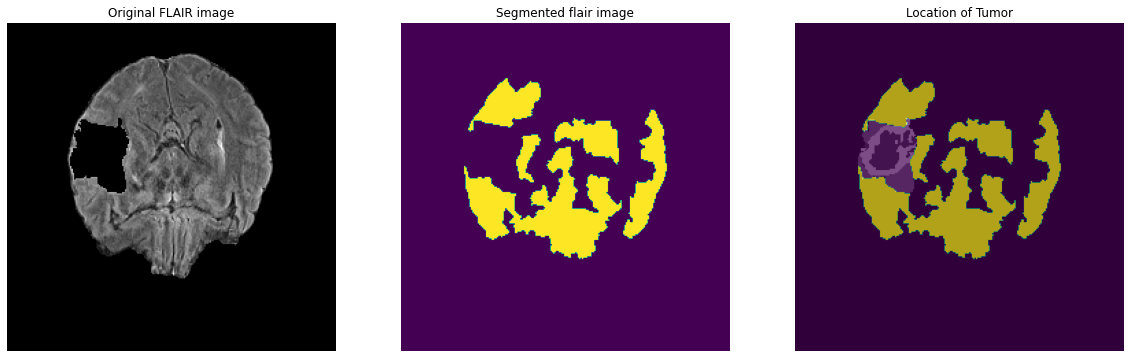

In [115]:
output[output< thresh_3d]=0
tumor_otsu_label = 1
output[output>0]=tumor_otsu_label


plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(output[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(output[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [116]:
tumor_hat = (flair_norm[output>0]).flatten()
nontumor_hat = flair_norm[output ==0]
nontumor_hat = nontumor_hat[nontumor_hat> tolerance]

In [117]:
np.mean(tumor_hat)

0.21732506112438293

In [118]:
np.std(tumor_hat)

0.035631273420600976

In [119]:
np.mean(nontumor_hat)

0.17287204797057515

In [120]:
np.std(nontumor_hat)

0.025977374595761164

In [121]:
ttest_ind(tumor_hat, nontumor_hat, equal_var=False)

Ttest_indResult(statistic=830.5226930972153, pvalue=0.0)

In [122]:
mean_diff = np.mean(tumor_hat) - np.mean(nontumor_hat)
mean_diff

0.044453013153807786